# Tutorial: Classification

Agenda:
1. Classification running example: Iris Flowers
2. Weight space & feature space intuition
3. Perceptron convergence proof
4. Gradient Descent for Multiclass Logisitc Regression

In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Classification with Iris

We're going to use the Iris dataset.

We will only work with the first 2 flower classes
(Setosa and Versicolour), and with just the first
two features: length and width of the sepal 

If you don't know what the sepal is, see this
diagram:
https://www.math.umd.edu/~petersd/666/html/iris_with_labels.jpg

In [2]:
from sklearn.datasets import load_iris
iris = load_iris()
print iris['DESCR']

Iris Plants Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
    :Summary Statistics:
    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20  0.76     0.9565  (high!)
    ============== ==== ==== ======= ===== ====================
    :Missing Attribute Values: None
    

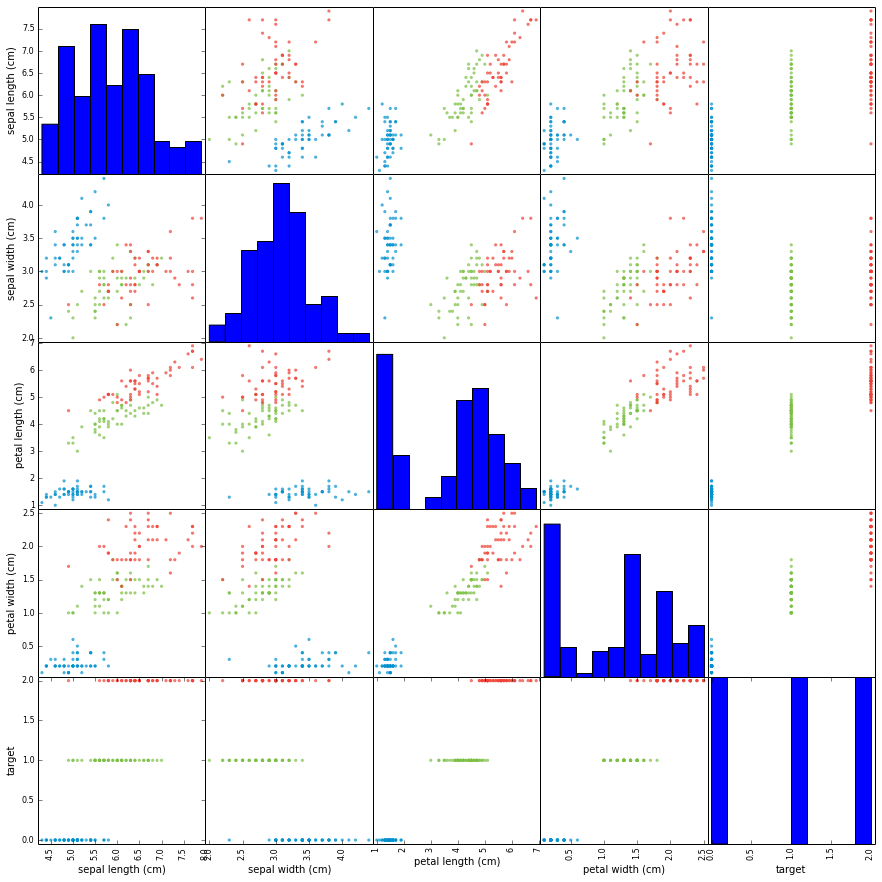

In [4]:
# code from
# http://stackoverflow.com/questions/21131707/multiple-data-in-scatter-matrix
from pandas.tools.plotting import scatter_matrix
import pandas as pd

iris_data = pd.DataFrame(data=iris['data'],columns=iris['feature_names'])
iris_data["target"] = iris['target']
color_wheel = {1: "#0392cf", 
               2: "#7bc043", 
               3: "#ee4035"}
colors = iris_data["target"].map(lambda x: color_wheel.get(x + 1))
ax = scatter_matrix(iris_data, color=colors, alpha=0.6, figsize=(15, 15), diagonal='hist')

In [5]:
# Select first 2 flower classes (~100 rows)
# And first 2 features

sepal_len = iris['data'][:100,0]
sepal_wid = iris['data'][:100,1]
labels = iris['target'][:100]

# We will also center the data
# This is done to make numbers nice, so that we have no
# need for biases in our classification. (You might not
# be able to remove biases this way in general.)

sepal_len -= np.mean(sepal_len)
sepal_wid -= np.mean(sepal_wid)

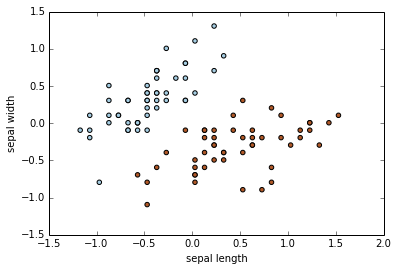

In [6]:
# Plot Iris

plt.scatter(sepal_len, 
            sepal_wid,
            c=labels,
            cmap=plt.cm.Paired)
plt.xlabel("sepal length")
plt.ylabel("sepal width")

### Plotting Decision Boundary

Plot decision boundary hypothese 

$$w_1 x_1 + w_2 x_2 \ge 0$$

for classification as Setosa.

In [7]:
def plot_sep(w1, w2, color='green'):
    '''
    Plot decision boundary hypothesis 
      w1 * sepal_len + w2 * sepal_wid = 0
    in input space, highlighting the hyperplane
    '''
    plt.scatter(sepal_len, 
                sepal_wid,
                c=labels,
                cmap=plt.cm.Paired)
    plt.title("Separation in Input Space")
    plt.ylim([-1.5,1.5])
    plt.xlim([-1.5,2])
    plt.xlabel("sepal length")
    plt.ylabel("sepal width")
    if w2 != 0:
        m = -w1/w2
        t = 1 if w2 > 0 else -1
        plt.plot(
            [-1.5,2.0], 
            [-1.5*m, 2.0*m], 
            '-y', 
            color=color)
        plt.fill_between(
            [-1.5, 2.0],
            [m*-1.5, m*2.0],
            [t*1.5, t*1.5],
            alpha=0.2,
            color=color)
    if w2 == 0: # decision boundary is vertical
        t = 1 if w1 > 0 else -1
        plt.plot([0, 0],
                 [-1.5, 2.0],
                 '-y',
                color=color)
        plt.fill_between(
            [0, 2.0*t],
            [-1.5, -2.0],
            [1.5, 2],
            alpha=0.2,
            color=color)

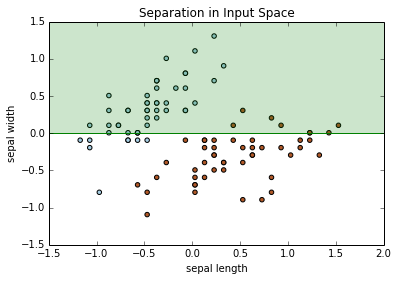

In [8]:
# Example hypothesis
#   sepal_wid >= 0

plot_sep(0, 1)

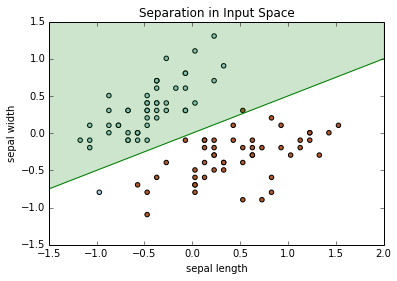

In [9]:
# Another example hypothesis:
#   -0.5*sepal_len + 1*sepal_wid >= 0

plot_sep(-0.5, 1)

(-0.97100000000000097, -0.79400000000000004)


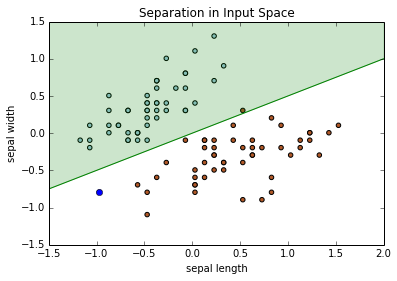

In [10]:
# We're going to hand pick one point and
# analyze that point:

a1 = sepal_len[41]
a2 = sepal_wid[41]
print (a1, a2) # (-0.97, -0.79)

plot_sep(-0.5, 1)
plt.plot(a1, a2, 'ob') # highlight the point

### Plot Constraints in Weight Space

We'll plot the constraints for some of the points
that we chose earlier.

In [11]:
def plot_weight_space(sepal_len, sepal_wid, lab=1,
                      color='steelblue',
                      maxlim=2.0):
    plt.title("Constraint(s) in Weight Space")
    plt.ylim([-maxlim,maxlim])
    plt.xlim([-maxlim,maxlim])
    plt.xlabel("w1")
    plt.ylabel("w2")

    if sepal_wid != 0:
        m = -sepal_len/sepal_wid
        t = 1*lab if sepal_wid > 0 else -1*lab
        plt.plot([-maxlim, maxlim], 
                 [-maxlim*m, maxlim*m], 
                 '-y',
                 color=color)
        plt.fill_between(
            [-maxlim, maxlim],     # x 
            [m*-maxlim, m*maxlim], # y-min
            [t*maxlim, t*maxlim],      # y-max
            alpha=0.2,
            color=color)
    if sepal_wid == 0: # decision boundary is vertical
        t = 1*lab if sepal_len > 0 else -1*lab
        plt.plot([0, 0], 
                 [-maxlim, maxlim], 
                 '-y',
                 color=color)
        plt.fill_between(
            [0, 2.0*t],
            [-maxlim, -maxlim],
            [maxlim, maxlim],
            alpha=0.2,
            color=color)

(-0.97100000000000097, -0.79400000000000004)


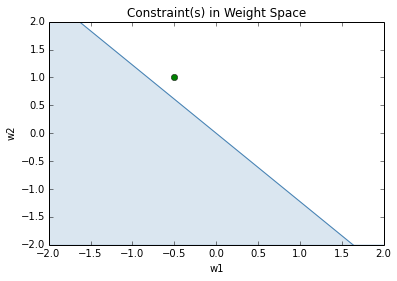

In [12]:
# Plot the constraint for the point identified earlier:

a1 = sepal_len[41]
a2 = sepal_wid[41]
print (a1, a2)

# Do this on the board first by hand

plot_weight_space(a1, a2, lab=1)

# Below is the hypothesis we plotted earlier
# Notice it falls outside the range.
plt.plot(-0.5, 1, 'og')

### Perceptron Learning Rule Example

We'll take one step using the perceptron learning rule

In [20]:
# Using the perceptron learning rule
# TODO: Fill in

w1 = -0.5 # + ...
w2 =  1   # + ...

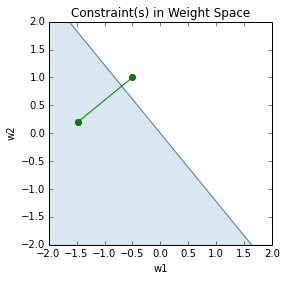

In [21]:
# This should bring the point closer to the boundary
# In this case, the step brought the point into the
# condition boundary
plot_weight_space(a1, a2, lab=1)
plt.plot(-0.5+a1, 1+a2, 'og')
# old hypothesis
plt.plot(-0.5, 1, 'og')
plt.plot([-0.5, -0.5+a1], [1, 1+a2], '-g')

plt.axes().set_aspect('equal', 'box')

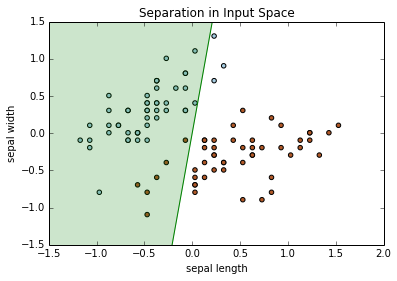

In [22]:
# Which means that the point (a1, a2) in input
# space is correctly classified.

plot_sep(-0.5+a1, 1+a2)

### Visualizing Multiple Constraints

We'll visualize multiple constraints in weight space.

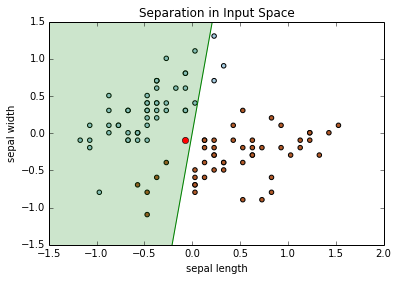

In [23]:
# Pick a second point
b1 = sepal_len[84]
b2 = sepal_wid[84]

plot_sep(-0.5+a1, 1+a2)
plt.plot(b1, b2, 'or') # plot the circle in red

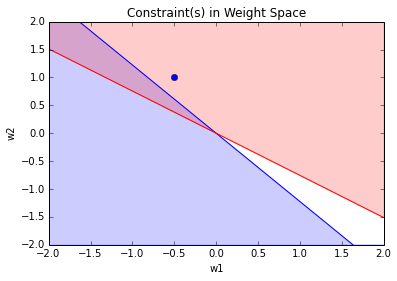

In [24]:
# our weights fall outside constraint of second pt.

plot_weight_space(a1, a2, lab=1, color='blue')
plot_weight_space(b1, b2, lab=-1, color='red')
plt.plot(w1, w2, 'ob')

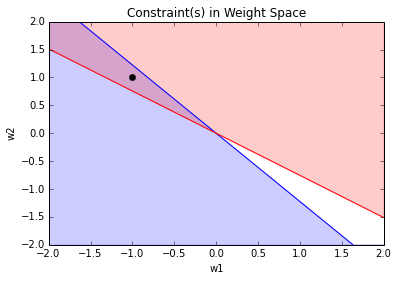

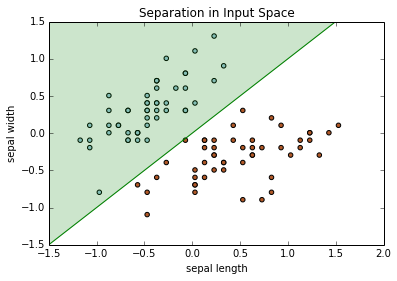

In [25]:
# Example of a separating hyperplane
plot_weight_space(a1, a2, lab=1, color='blue')
plot_weight_space(b1, b2, lab=-1, color='red')
plt.plot(-1, 1, 'ok')
plt.show()
plot_sep(-1, 1)
plt.show()

## Perceptron Convergence Proof:

(From Geoffrey Hinton's slides 2d)

Hopeful claim: Every time the perceptron makes a mistake, the learning algo moves the current weight vector closer to all feasible weight vectors

BUT: weight vector may not get close to feasible vector in the boundary

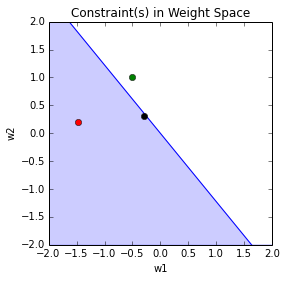

In [26]:
# The feasible region is inside the intersection of these two regions:
plot_weight_space(a1, a2, lab=1, color='blue')
#plot_weight_space(b1, b2, lab=-1, color='red')

# This is a vector in the feasible region.
plt.plot(-0.3, 0.3, 'ok')

# We started with this point
plt.plot(-0.5, 1, 'og')

# And ended up here
plt.plot(-0.5+a1, 1+a2, 'or')

# Notice that red point is further away to black than the green

plt.axes().set_aspect('equal', 'box')

* So consider “generously feasible” weight vectors that lie within the feasible region by a margin at least as great as the length of the input vector that defines each constraint plane.
* Every time the perceptron makes a mistake, the squared distance to all of these generously feasible weight vectors is always decreased by at least the squared length of the update vector.

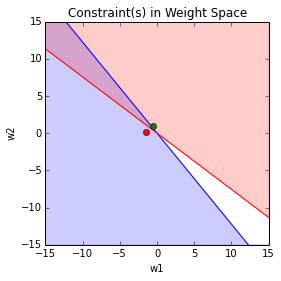

In [27]:
plot_weight_space(a1, a2, lab=1, color='blue' ,maxlim=15)
plot_weight_space(b1, b2, lab=-1, color='red', maxlim=15)

# We started with this point
plt.plot(-0.5, 1, 'og')
plt.plot(-0.5+a1, 1+a2, 'or')
plt.axes().set_aspect('equal', 'box')

# red is closer to "generously feasible" vectors on the top left

### Inform Sketch of Proof of Convergence

* Each time the perceptron makes a mistake, the current weight vector moves to decrease its squared distance from every weight vector in the “generously feasible” region.
* The squared distance decreases by at least the squared length of the input vector.
* So after a finite number of mistakes, the weight vector must lie in the feasible region if this region exists.

## Gradient Descent for Multiclass Logisitc Regression

Multiclass logistic regression:

\begin{align}
{\bf z} &= {\bf W}{\bf x} + {\bf b} \\
{\bf y} &= \text{softmax}({\bf z}) \\
{\mathcal L}_\text{CE} &= -{\bf t}^T(\log \bf{y}) 
\end{align}

Draw out the shapes on the board before continuing.

In [28]:
# Aside: lots of functions work on vectors

print np.log([1.5,2,3])
print np.exp([1.5,2,3])

[ 0.40546511  0.69314718  1.09861229]
[  4.48168907   7.3890561   20.08553692]


Start by expanding the cross entropy loss so that we can work with it

$$ {\mathcal L}_\text{CE} = -\sum_l t_l \log(y_l)$$

### Main setup

We'll take the derivative with respect to the loss:

\begin{align}
\frac{\partial {\mathcal L}_\text{CE}}{\partial w_{kj}} &= 
  \frac{\partial }{\partial w_{kj}} (-\sum_l t_l \log(y_l)) \\
&= -\sum_l \frac{t_l}{y_l} \frac{\partial y_l}{\partial w_{kj}}
\end{align}

Normally in calculus we have the rule:

\begin{align}
\frac{\partial y_l}{\partial w_{kj}} &= 
  \sum_m \frac{\partial y_l}{\partial z_m} \frac{\partial z_m}{\partial w_{kj}}
\end{align}

But $w_{kj}$ is independent of $z_m$ for $m \ne k$, so 

\begin{align}
\frac{\partial y_l}{\partial w_{kj}} &= 
  \frac{\partial y_l}{\partial z_k} \frac{\partial z_k}{\partial w_{kj}}
\end{align}

AND

$$\frac{\partial z_k}{\partial w_{kj}} = x_j$$


Thus

\begin{align}
\frac{\partial {\mathcal L}_\text{CE}}{\partial w_{kj}} &= 
-\sum_l \frac{t_l}{y_l} \frac{\partial y_l}{\partial z_k} \frac{\partial z_k}{\partial w_{kj}} \\
&= 
-\sum_l \frac{t_l}{y_l} \frac{\partial y_l}{\partial z_k} x_j \\
&= x_j (-\sum_l \frac{t_l}{y_l} \frac{\partial y_l}{\partial z_k}) \\
&= x_j \frac{\partial {\mathcal L}_\text{CE}}{\partial z_k} 
\end{align}

### Derivative with respect to $z_k$

But we can show (on board) that

$$
\frac{\partial y_l}{\partial z_k} = y_k (I_{k,l} - y_l)
$$

Where $I_{k,l} = 1$ if $k=l$ and $0$ otherwise.



Therefore

\begin{align}
\frac{\partial {\mathcal L}_\text{CE}}{\partial z_k} &= 
-\sum_l \frac{t_l}{y_l} (y_k (I_{k,l} - y_l)) \\
&= -\frac{t_k}{y_k} y_k(1 - y_k) - \sum_{l \ne k} \frac{t_l}{y_l} (-y_k y_l) \\
&= - t_k(1 - y_k) + \sum_{l \ne k} t_l y_k \\
&= -t_k + t_k y_k + \sum_{l \ne k} t_l y_k \\
&= -t_k + \sum_{l} t_l y_k \\
&= -t_k + y_k \sum_{l} t_l  \\
&= -t_k + y_k \\
&= y_k - t_k
\end{align}

### Putting it all together

\begin{align}
\frac{\partial {\mathcal L}_\text{CE}}{\partial w_{kj}}
&= x_j (y_k - t_k)
\end{align}

### Vectorization

Outer product.

\begin{align}
\frac{\partial {\mathcal L}_\text{CE}}{\partial {\bf W}}
&= (\bf{y} - \bf{t}) \bf{x}^T \\
\frac{\partial {\mathcal L}_\text{CE}}{\partial {\bf b}}
&= (\bf{y} - \bf{t})
\end{align}



In [29]:
def softmax(x):
    #return np.exp(x) / np.sum(np.exp(x))
    return np.exp(x - max(x)) / np.sum(np.exp(x - max(x)))

In [30]:
x1 = np.array([1,3,3])
softmax(x1)

array([ 0.06337894,  0.46831053,  0.46831053])

In [31]:
x2 = np.array([1000,3000,3000])
softmax(x2)

array([ 0. ,  0.5,  0.5])

In [32]:
def gradient(W, b, x, t):
    '''
    Gradient update for a single data point.
        returns dW and db
    This is meant to show how to implement the
    obtained equation in code. (not tested)
    '''
    z = np.matmul(W, x) + b
    y = softmax(z)
    dW = np.matmul(x, (y-t).T)
    db = (y-t)
    return dW, db